## Proyecto Precio Petróleo con GARCH y ARIMA ##

In [1]:
!pip install yfinance


In [1]:
import yfinance as yf
import pandas as pd

# Descargar los datos de petróleo crudo WTI
data = yf.download("CL=F", start="2018-01-01", end="2025-04-04")

# Extraer solo la columna 'Close' y resetear el índice
precio_petroleo = data[['Close']].reset_index()

# Renombrar columnas 
precio_petroleo.columns = ['Fecha', 'Precio_Cierre']


print(precio_petroleo.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

       Fecha  Precio_Cierre
0 2018-01-02      60.369999
1 2018-01-03      61.630001
2 2018-01-04      62.009998
3 2018-01-05      61.439999
4 2018-01-08      61.730000


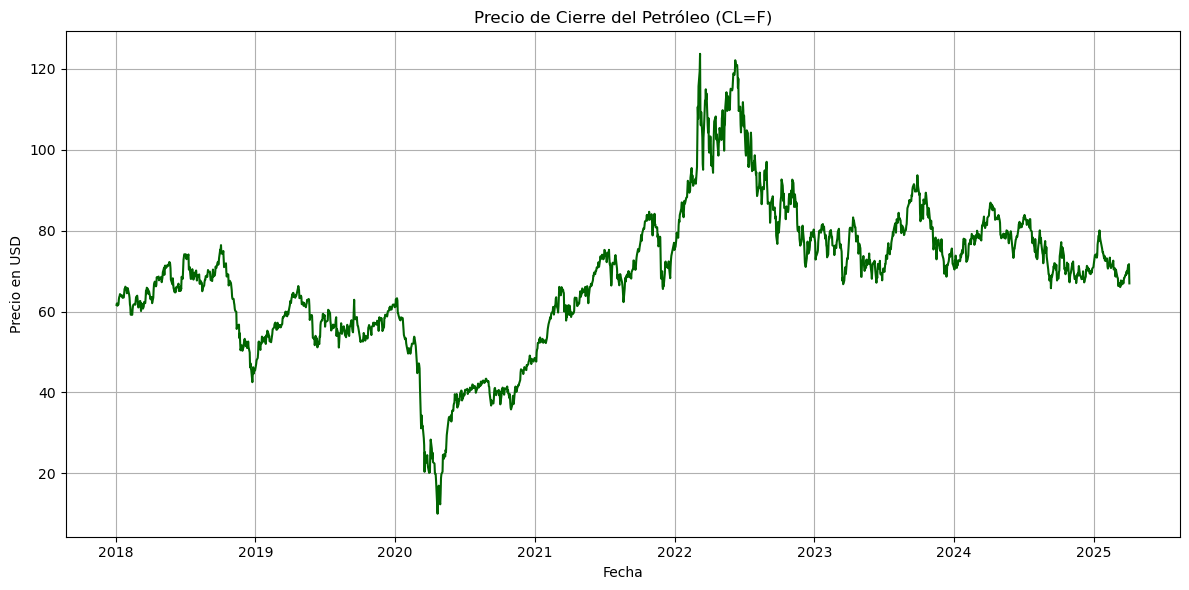

In [10]:
import matplotlib.pyplot as plt

# Convertir a date time en caso de que Fecha no tenga ese formato
precio_petroleo['Fecha'] = pd.to_datetime(precio_petroleo['Fecha'])

# Gráfica de la serie de tiempo del precio cierre
plt.figure(figsize=(12, 6))
plt.plot(precio_petroleo['Fecha'], precio_petroleo['Precio_Cierre'], color='darkgreen')
plt.title('Precio de Cierre del Petróleo (CL=F)')
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
!pip install pmdarima


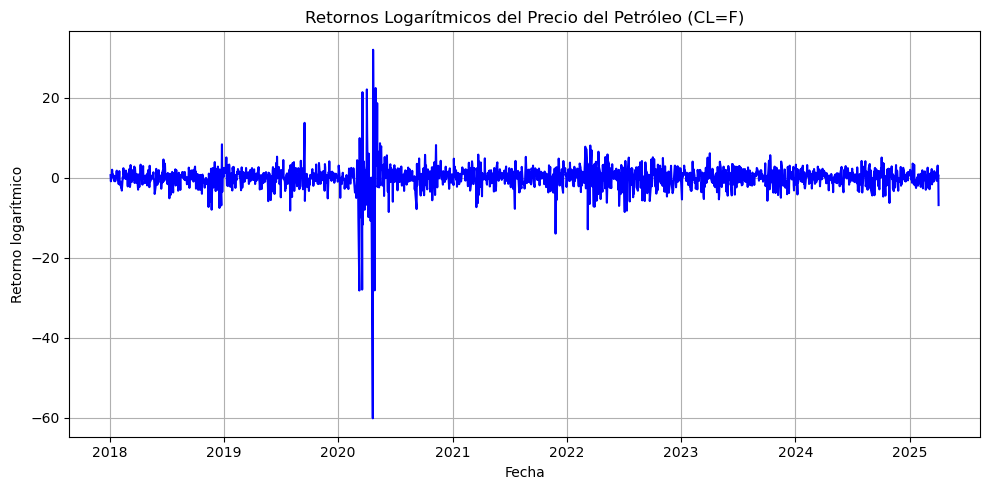

       Fecha  LogRendimientos
2 2018-01-04         0.614685
3 2018-01-05        -0.923457
4 2018-01-08         0.470896
5 2018-01-09         1.972956
6 2018-01-10         0.964207


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Eliminar filas donde el Precio_Cierre sea cero o negativo
precio_petroleo = precio_petroleo[precio_petroleo['Precio_Cierre'] > 0]

# Calcular los rendimientos logarítmicos escalados a 100
precio_petroleo['LogRendimientos'] = np.log(precio_petroleo['Precio_Cierre'] / precio_petroleo['Precio_Cierre'].shift(1))*100

# Eliminar valores nulos
precio_petroleo.dropna(inplace=True)

# Graficar los retornos logarítmicos
plt.figure(figsize=(10,5))
plt.plot(precio_petroleo['Fecha'], precio_petroleo['LogRendimientos'], color='blue')
plt.title('Retornos Logarítmicos del Precio del Petróleo (CL=F)')
plt.xlabel('Fecha')
plt.ylabel('Retorno logarítmico')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar los primeros registros de los rendimientos porcentuales
print(precio_petroleo[['Fecha', 'LogRendimientos']].head())




C:\Users\astra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\astra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


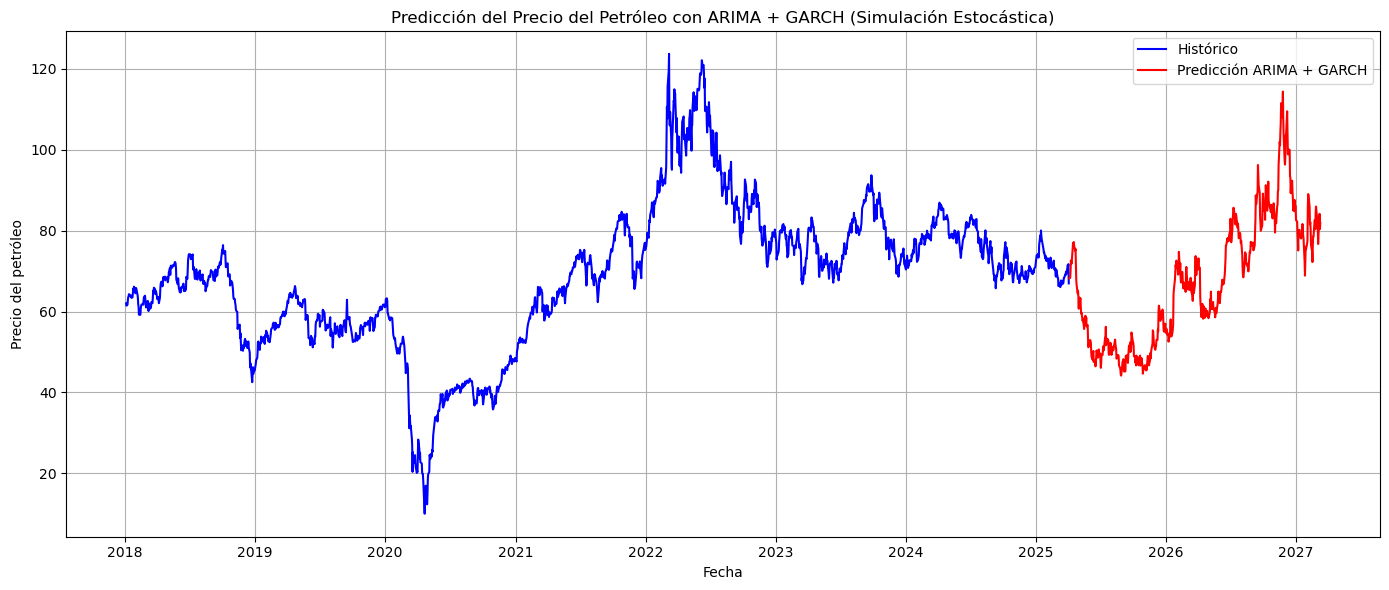

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from pmdarima import auto_arima



# 1. Ajustar modelo ARIMA automáticamente
modelo_auto_arima = auto_arima(precio_petroleo['LogRendimientos'], seasonal=False, stepwise=True,
                                suppress_warnings=True, error_action='ignore')

# 2. Extraer residuos y ajustar modelo GARCH
residuos_arima = modelo_auto_arima.resid()
modelo_garch = arch_model(residuos_arima, vol='Garch', p=1, q=1)
resultado_garch = modelo_garch.fit(disp='off')

# 3. Definir horizonte de predicción (2 años)
horizonte = 504  

# 4. Predicción ARIMA
forecast_arima = modelo_auto_arima.predict(n_periods=horizonte)

# 5. Predicción GARCH (volatilidad esperada)
forecast_garch = resultado_garch.forecast(horizon=horizonte)
varianzas = forecast_garch.variance.values[-1]
stds = np.sqrt(varianzas)

# 6. Simular rendimientos futuros combinando ARIMA + GARCH
np.random.seed(42) 
rendimientos_simulados = forecast_arima + np.random.normal(0, stds, size=horizonte)

# 7. Simular precios futuros
ultimo_precio = precio_petroleo['Precio_Cierre'].iloc[-1]
precios_futuros = [ultimo_precio]

for r in rendimientos_simulados:
    precios_futuros.append(precios_futuros[-1] * np.exp(r / 100))
precios_futuros = precios_futuros[1:]

# 8. Generar fechas futuras
ultima_fecha = precio_petroleo['Fecha'].iloc[-1]
fechas_futuras = pd.bdate_range(start=ultima_fecha + pd.Timedelta(days=1), periods=horizonte)

# 9. Graficar resultados
plt.figure(figsize=(14,6))
plt.plot(precio_petroleo['Fecha'], precio_petroleo['Precio_Cierre'], label='Histórico', color='blue')
plt.plot(fechas_futuras, precios_futuros, label='Predicción ARIMA + GARCH', color='red')
plt.title('Predicción del Precio del Petróleo con ARIMA + GARCH (Simulación Estocástica)')
plt.xlabel('Fecha')
plt.ylabel('Precio del petróleo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
print(modelo_auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1822
Model:               SARIMAX(3, 0, 4)   Log Likelihood               -4734.936
Date:                Fri, 11 Apr 2025   AIC                           9485.873
Time:                        23:49:28   BIC                           9529.934
Sample:                             0   HQIC                          9502.128
                               - 1822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8973      0.044    -20.233      0.000      -0.984      -0.810
ar.L2         -0.7814      0.039    -20.006      0.000      -0.858      -0.705
ar.L3         -0.7806      0.032    -24.046      0.0